In [1]:
# What drives happiness?
# What are the factors that influence suicide rate?

# import dependencies
from config import census_key
import requests
from pprint import pprint
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import math

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend as K

Using TensorFlow backend.


In [2]:
# we will want p-values for each variable / beta coefficient
# scikit-learn's LinearRegression doesn't calculate this information but you can easily extend the class to do it
# from https://gist.github.com/brentp/5355925
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self

In [3]:
# Get census data using api
# Variables here:
# https://api.census.gov/data/2017/acs/acs5/variables.html

vars_full = {

    # Education
    'B15001_046E': 'Estimate!!Total!!Female!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_005E': 'Estimate!!Total!!Male!!18 to 24 years!!9th to 12th grade no diploma',
    'B15001_044E': 'Estimate!!Total!!Female!!18 to 24 years',
    'B15001_003E': 'Estimate!!Total!!Male!!18 to 24 years',

    # Unemployment
    'B23001_048E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian',
    'B23001_041E': 'Estimate!!Total!!Male!!35 to 44 years!!In labor force!!Civilian',
    'B23001_034E': 'Estimate!!Total!!Male!!30 to 34 years!!In labor force!!Civilian',
    'B23001_050E': 'Estimate!!Total!!Male!!45 to 54 years!!In labor force!!Civilian!!Unemployed',
    'B23001_043E': 'Estimate!!Total!!Male!!35 to 44 years!!In labor force!!Civilian!!Unemployed',
    'B23001_036E': 'Estimate!!Total!!Male!!30 to 34 years!!In labor force!!Civilian!!Unemployed',

    # Health Insurance
    'B27001_012E': 'Estimate!!Total!!Male!!26 to 34 years',
    'B27001_015E': 'Estimate!!Total!!Male!!35 to 44 years',
    'B27001_018E': 'Estimate!!Total!!Male!!45 to 54 years',
    'B27001_014E': 'Estimate!!Total!!Male!!26 to 34 years!!No health insurance coverage',
    'B27001_017E': 'Estimate!!Total!!Male!!35 to 44 years!!No health insurance coverage', 
    'B27001_020E': 'Estimate!!Total!!Male!!45 to 54 years!!No health insurance coverage',

    # Poverty
    'B17001_001E': 'Estimate!!Total',
    'B17001_002E': 'Estimate!!Total!!Income in the past 12 months below poverty level',

    # Veteran status
    'B21001_004E': 'Estimate!!Total!!Male',
    'B21001_005E': 'Estimate!!Total!!Male!!Veteran',

    # Disability
    'B18101_013E': 'Estimate!!Total!!Male!!35 to 64 years!!With a disability',
    'B18101_012E': 'Estimate!!Total!!Male!!35 to 64 years',

    # Housing units
    'B25003_003E': 'Estimate!!Total!!Renter occupied',
    'B25003_001E': 'total',

    # Living arrangement
    'B09021_002E': 'Estimate!!Total!!Lives alone',
    'B09021_001E': 'Estimate!!Total',

    # Education
    'B15001_026E': 'Estimate!!Total!!Male!!35 to 44 years!!Graduate or professional degree',
    'B15001_018E': 'Estimate!!Total!!Male!!25 to 34 years!!Graduate or professional degree',
    'B15001_019E': 'Estimate!!Total!!Male!!35 to 44 years',
    'B15001_011E': 'Estimate!!Total!!Male!!25 to 34 years',

    # Population and Race
    'B01003_001E': 'Total population',
    'B02001_004E': 'Estimate!!Total!!American Indian and Alaska Native alone',
    'B02001_006E': 'Estimate!!Total!!Native Hawaiian and Other Pacific Islander alone'
}
vars = list(vars_full.keys())

In [4]:
# Variables inspected that showed little or no correlation

#     'B19083_001E': 'GINI INDEX OF INCOME INEQUALITY',
#     # Food Stamps
#     'B22001_004E': 'Estimate!!Total!!Household received Food Stamps/SNAP in the past 12 months!!No people in household 60 years or over',
#     'B22001_005E': 'Estimate!!Total!!Household did not receive Food Stamps/SNAP in the past 12 months',
#   Travel Time
#     'B08012_013E': 'Estimate!!Total!!90 or more minutes',
#     'B08012_012E': 'Estimate!!Total!!60 to 89 minutes',
#     'B08012_001E': 'Estimate!!Total',
#   Occupation
#     'B24031_005E': 'Estimate!!Total!!Construction',
#     'B24031_001E': 'total',
#   Time leaving for work
#     'B08011_002E': 'Estimate!!Total!!12 00 a.m. to 4 59 a.m.',
#     'B08011_003E': '5-5:30',
#     'B08011_004E': '5:30-6',
#     'B08011_001E': 'Estimate!!Total'
#    Means of transport
#     'B08006_014E': 'Estimate!!Total!!Bicycle',
#     'B08006_001E': 'Estimate!!Total',

In [5]:
url_start = 'https://api.census.gov/data/2017/acs/acs5?get='
url_mid = 'NAME,' + ','.join(vars)
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)

In [6]:
df = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df['state'] + df['county']
county_code = [code.lstrip('0') for code in county_code]
df['County Code'] = county_code
df = df.set_index('County Code')
# # Find Yolo County. Codes here: https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
# df.loc[(df['state'] == '06') & (df['county'] == '113')]
# df_full[df_full['NAME'].str.match('Yolo')]

In [7]:
# Import suicide rates csv
path_csv = 'suicide_rates.csv'
df_grim = pd.read_csv(path_csv)
# convert county code column to string
df_grim['County Code'] = df_grim['County Code'].astype(str)
df_grim = df_grim.set_index('County Code')
# Calculate suicide rate per 100k
df_grim['Suicide Rate'] = df_grim['Deaths'] / df_grim['Population'] *100000 

In [8]:
# Import county land area csv
path_csv = 'county_areas.csv'
df_areas = pd.read_csv(path_csv)
df_areas['County Code'] = df_areas['County Code'].astype(str)
df_areas = df_areas.set_index('County Code')

In [9]:
# Import number of mental health providers

def floatify(x):
    if type(x) == str:
        y = x.replace(',', '')
        y = float(y)
        return y

path_csv = 'providers.csv'
df_providers = pd.read_csv(path_csv)
NAME = df_providers['County'] + ' County, ' + df_providers['State']
df_providers['NAME'] = NAME
df_providers = df_providers.drop(['State', 'County'], axis=1)
df_providers = df_providers.set_index('NAME')
df_providers['# Mental Health Providers'] = [floatify(x) for x in df_providers['# Mental Health Providers']]
df_providers = df_providers.dropna()

In [10]:
# Import county daylight csv
path_csv = 'county_daylight.csv'
df_daylight = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_daylight['County Code'] = df_daylight['County Code'].astype(str)
df_daylight = df_daylight.set_index('County Code')
df_daylight = df_daylight.drop(['County'], axis=1)

In [16]:
# Import number of firearms sellers csv
path_csv = 'gun_seller_counts.csv'
df_gunSellers = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_gunSellers = df_gunSellers.rename(columns = {'Lic Cnty': 'Gun Seller Count'})
df_gunSellers['County Code'] = df_gunSellers['County Code'].astype(str)
df_gunSellers = df_gunSellers.set_index('County Code')

In [17]:
# Get median income data for 2017
# from https://api.census.gov/data/2017/acs/acs5/profile/variables.html
# 'DP03_0062E' #Estimate!!INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
url_start = 'https://api.census.gov/data/2017/acs/acs5/profile?get='
url_mid = 'NAME,' + 'DP03_0062E' #median income
url_end = '&for=county:*&key='
url = url_start + url_mid + url_end + census_key
response = requests.get(url)
# store in dataframe
df_income_2017 = pd.DataFrame(response.json()[1:], columns=response.json()[0])
county_code = df_income_2017['state'] + df_income_2017['county']
county_code = [code.lstrip('0') for code in county_code]
df_income_2017['County Code'] = county_code
df_income_2017 = df_income_2017.set_index('County Code')
# Get median income data for 2009
# downloaded from https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml
path_csv = 'acs5_2009_median_income.csv'
df_income_2009 = pd.read_csv(path_csv, encoding = "ISO-8859-1")
df_income_2009['County Code'] = df_income_2009['County Code'].astype(str)
df_income_2009 = df_income_2009.set_index('County Code')
# Join 2009, 2017 Median Income tables
df_incomes = df_income_2017.join(df_income_2009, on='County Code', how='inner')
df_incomes = df_incomes[['DP03_0062E', 'Median household income (dollars)']]
df_incomes = df_incomes.rename(columns = {'DP03_0062E': 'income_2017', 'Median household income (dollars)': 'income_2009'})
# convert to float
df_incomes['income_2017'] = [float(i) for i in df_incomes['income_2017']]
df_incomes['income_2009'] = [float(i) for i in df_incomes['income_2009']]

In [81]:
# Join census, area, and suicide dataframes
df_full = df.join(df_grim, on='County Code', how='inner') \
            .join(df_areas, on='County Code', how='inner') \
            .join(df_incomes, on='County Code', how='inner') \
            .join(df_gunSellers, on='County Code', how='left') \
#             .join(df_providers, on='NAME', how='inner')
#             .join(df_daylight, on='County Code', how='inner') \

# convert numerical columns into float
for thisVar in vars:
    df_full[thisVar] = [float(i) for i in df_full[thisVar]]
    
# calculate population density
df_full['Population Density'] = df_full['B01003_001E'] / df_full['ALAND_SQMI']
    
# Order by highest suicide rate
df_full = df_full.sort_values(by='Suicide Rate', ascending=False)
print(len(df_full))

2362


In [92]:
# Create clean dataframe with calculated variables of interest
df_clean = df_full[['NAME', 'Suicide Rate', 'Population Density']]
df_clean.is_copy = False # ignore those warnings lol
df_clean['Median Income'] = df_full['income_2017']
df_clean['Log Population Density'] = [math.log(i, 10) for i in df_full['Population Density']]
df_clean['Population'] = df_full['B01003_001E']
df_clean['HS Drop Out Rate'] = (df_full['B15001_046E'] + df_full['B15001_005E']) / (df_full['B15001_044E'] + df_full['B15001_003E'])
df_clean['Unemployment Rate'] = (df_full['B23001_050E'] + df_full['B23001_043E'] + df_full['B23001_036E']) / (df_full['B23001_048E'] + df_full['B23001_041E'] + df_full['B23001_034E'])
df_clean['Uninsured Rate'] = (df_full['B27001_014E'] + df_full['B27001_017E'] + df_full['B27001_020E']) / (df_full['B27001_012E'] + df_full['B27001_015E'] + df_full['B27001_018E'])
df_clean['Poverty Rate'] = df_full['B17001_002E'] / df_full['B17001_001E']
df_clean['Veteran Rate'] = df_full['B21001_005E'] / df_full['B21001_004E']
df_clean['Disability Rate'] = df_full['B18101_013E'] / df_full['B18101_012E']
df_clean['Housing Renter Rate'] = df_full['B25003_003E'] / df_full['B25003_001E']
df_clean['Living Alone Rate'] = df_full['B09021_002E'] / df_full['B09021_001E']
df_clean['Professional Rate'] = (df_full['B15001_018E'] + df_full['B15001_026E']) / (df_full['B15001_011E'] + df_full['B15001_019E'])
df_clean['Native American Rate'] = df_full['B02001_004E'] / df_full['B01003_001E']
df_clean['Gun Seller Density'] = df_full['Gun Seller Count'] / df_full['B01003_001E'] * 100000

# df_clean['Daylight'] = df_full['Avg Daily Sunlight (KJ/m²)']
# df_clean['People per Mental Health Provider'] = df_full['Population'] / df_full['# Mental Health Providers']
# df_clean['Gun Seller Density'] = df_clean['Gun Seller Density'].fillna(value=0)

df_clean.head(5)

C:\Users\Dov\Anaconda3\envs\DovPython\lib\site-packages\pandas\core\generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\Dov\Anaconda3\envs\DovPython\lib\site-packages\pandas\core\generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


,NAME,Suicide Rate,Population Density,Median Income,Log Population Density,Population,HS Drop Out Rate,Unemployment Rate,Uninsured Rate,Poverty Rate,Veteran Rate,Disability Rate,Housing Renter Rate,Living Alone Rate,Professional Rate,Native American Rate,Gun Seller Density
County Code,,,,,,,,,,,,,,,,,
2180,"Nome Census Area, Alaska",68.835665,0.429647,53821.0,-0.366888,9869.0,0.169922,0.181356,0.442849,0.249424,0.117783,0.160747,0.394201,0.094756,0.029775,0.735333,131.725605
38085,"Sioux County, North Dakota",63.443150,4.040027,40795.0,0.606384,4420.0,0.370288,0.241192,0.458108,0.371409,0.108108,0.195335,0.558348,0.077577,0.003752,0.839367,NaN
2290,"Yukon-Koyukuk Census Area, Alaska",57.832719,0.037458,37819.0,-1.426453,5453.0,0.209979,0.204819,0.535750,0.254731,0.136449,0.246154,0.296069,0.166396,0.023513,0.709518,128.369705
8027,"Custer County, Colorado",57.606239,6.099162,41330.0,0.785270,4505.0,0.116981,0.155015,0.349882,0.156681,0.362123,0.175270,0.181080,0.143497,0.037037,0.009545,NaN
46031,"Corson County, South Dakota",57.336710,1.691303,32260.0,0.228221,4177.0,0.426020,0.292632,0.396333,0.478544,0.173402,0.191489,0.465698,0.103039,0.006250,0.677041,NaN


Text(0, 0.5, 'Count')

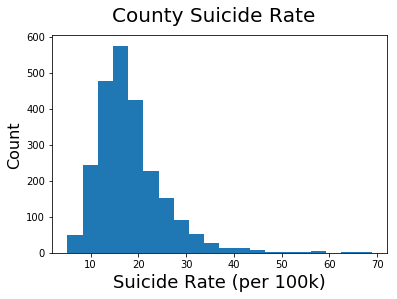

In [84]:
n_bins = 20
fig = plt.figure()
plt.hist(df_clean['Suicide Rate'], bins=n_bins)
fig.suptitle('County Suicide Rate', fontsize=20)
plt.xlabel('Suicide Rate (per 100k)', fontsize=18)
plt.ylabel('Count', fontsize=16)

Slope = -0.000137693374616869
r-squared = 0.0693249836137168
p-value = 9.424633846014432e-39


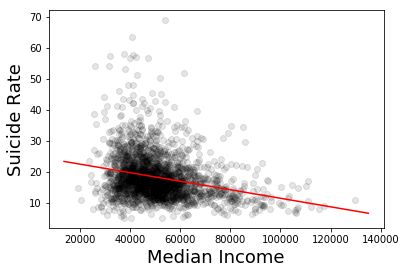

In [109]:
# Plot single variable (Median Income) against suicide rate

# Define x and y
x = df_clean['Median Income']
y = df_clean['Suicide Rate']

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
plt.ylabel('Suicide Rate', fontsize=18)
plt.xlabel('Median Income', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Slope = 7.367149855529273
r-squared = 0.13486230946268968
p-value = 4.697371324985892e-30


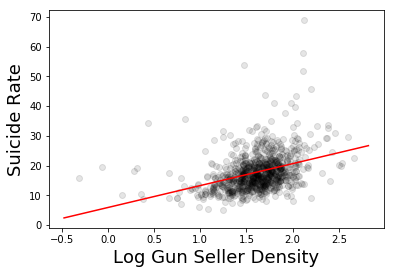

In [108]:
# Plot single variable (Median Income) against suicide rate

# Define x and y
mask = ~np.isnan(df_clean['Gun Seller Density'].values)
x = [math.log(i, 10) for i in df_clean['Gun Seller Density'][mask]]
y = df_clean['Suicide Rate'][mask]

# Plot
fig = plt.scatter(x, y, c='black', alpha=0.1)
axes = plt.gca()
plt.ylabel('Suicide Rate', fontsize=18)
plt.xlabel('Log Gun Seller Density', fontsize=18)


# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# Plot a line from slope and intercept
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, '-', color="red")
print(f"Slope = {slope}")
print(f"r-squared = {r_value**2}")
print(f"p-value = {p_value}")
# plt.savefig("happySauce_fig01.png")

Median Income
Slope = -0.000137693374616869
r-squared = 0.0693249836137168
p-value = 9.424633846014432e-39


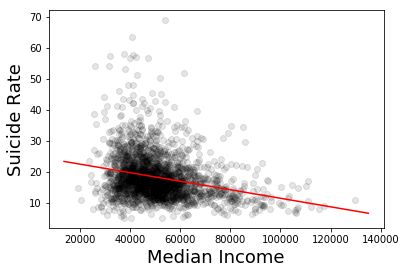

Log Population Density
Slope = -6.108286810291233
r-squared = 0.3272379287351101
p-value = 2.1587276126272736e-205


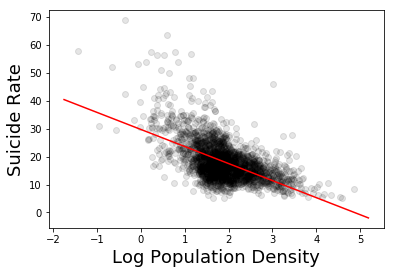

HS Drop Out Rate
Slope = 33.988709728517655
r-squared = 0.08624282158322402
p-value = 3.357344563211467e-48


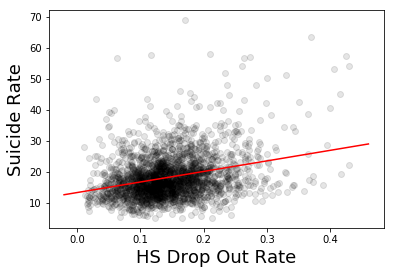

Veteran Rate
Slope = 48.204113919417445
r-squared = 0.10843890927949432
p-value = 7.492949003445968e-61


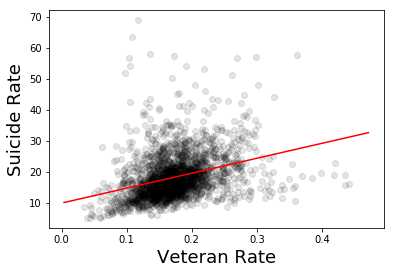

Disability Rate
Slope = 36.69636386669959
r-squared = 0.09624069802218481
p-value = 7.316942443574141e-54


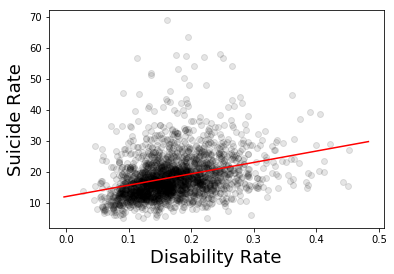

Housing Renter Rate
Slope = -17.953750906673974
r-squared = 0.04211100075381753
p-value = 7.096972510750349e-24


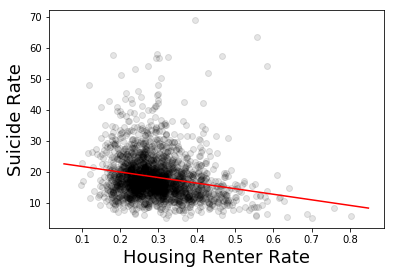

Living Alone Rate
Slope = 40.22210196882358
r-squared = 0.025212242959761485
p-value = 8.349699228469852e-15


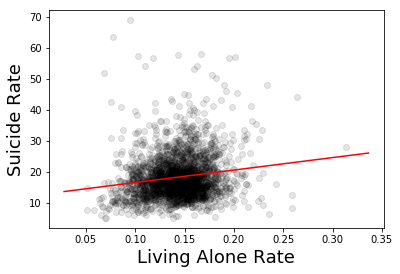

Professional Rate
Slope = -48.948872526669604
r-squared = 0.09992326013593585
p-value = 5.805232497887831e-56


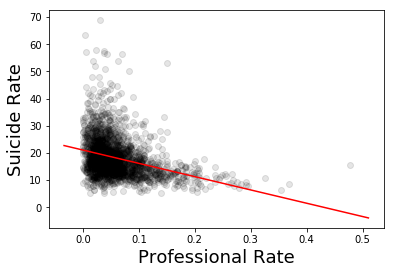

Native American Rate
Slope = 35.448472985125534
r-squared = 0.12229021699053177
p-value = 6.676371395632882e-69


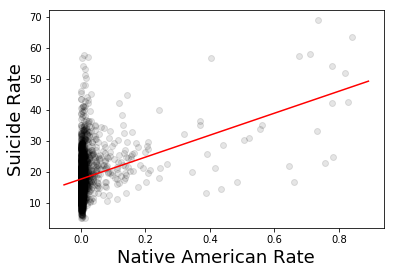

Poverty Rate
Slope = 13.873179066373158
r-squared = 0.01368067265528543
p-value = 1.190458280759984e-08


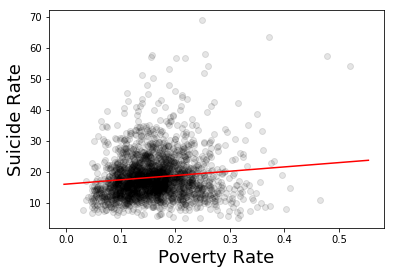

Gun Seller Density
Slope = 0.02063546925224765
r-squared = 0.011059061373399999
p-value = 3.0163379733375014e-07


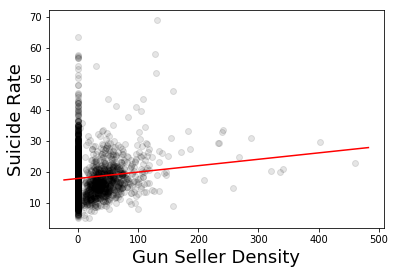

In [87]:
# Plot all variables against suicide rate

# List of all variables that will be in the multiple regression model

# vars_model = ['Median Income', 'Log Population Density', 'HS Drop Out Rate', 'Unemployment Rate', 'Uninsured Rate', 'Poverty Rate', \
#              'Veteran Rate', 'Disability Rate', 'Housing Renter Rate', 'Living Alone Rate', 'Professional Rate', 'Native American Rate', \
#               'Daylight', 'People per Mental Health Provider', 'Log Gun Seller Density']

vars_model = ['Median Income', 'Log Population Density', 'HS Drop Out Rate', 'Veteran Rate', 'Disability Rate', \
              'Housing Renter Rate', 'Living Alone Rate', 'Professional Rate', 'Native American Rate', 'Poverty Rate', \
              'Gun Seller Density']

# Plot all graphs
plt.figure()
for thisVar in vars_model:
    # Define x and y
    x = df_clean[thisVar]
    y = df_clean['Suicide Rate']
    # Plot data points
    plt.scatter(x, y, c='black', alpha=0.1)
    plt.ylabel('Suicide Rate', fontsize=18)
    plt.xlabel(thisVar, fontsize=18)
    # Linear Regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    # Plot a line from slope and intercept
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color="red")
    print(thisVar)
    print(f"Slope = {slope}")
    print(f"r-squared = {r_value**2}")
    print(f"p-value = {p_value}")
    plt.show()


In [88]:
# Define variables for multiple regression model
X = df_clean[[*vars_model]]
y = df_clean['Suicide Rate'].values.reshape(-1, 1)
# print(X.shape, y.shape)
# Split data into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42) # 70% data for train, 30% for test
print(f'Train data: {len(y_train)} data points')
print(f'Test data: {len(y_test)} data points')


# Scale the data so the mean is 0 and the standard deviation is 1
# This will allow us to directly compare beta coefficients in the full model
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Train data: 1653 data points
Test data: 709 data points


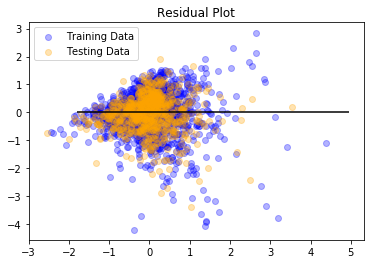

In [89]:
# Fit model and plot the residuals
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data", alpha=0.3)
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data", alpha=0.3)
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [90]:
# Evaluate multiple regression model using test data set
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.4407347236950018, R2: 0.4670556181350108


In [91]:
# Create dataframe with multiple regression beta coefficients and p-values
data = {'Variable': vars_model, 'Beta Coefficient': model.coef_.tolist()[0], 'p-value': model.p.tolist()[0]}
df_lm = pd.DataFrame(data)
# alpha = 1-(1-0.05)**(1/len(vars_model)) # corrected for multiple comparisons (Sidak)
alpha = 0.05
df_lm['Significant'] = df_lm['p-value'] < alpha

df_lm = df_lm.sort_values('Beta Coefficient', ascending =False)
df_lm

,Variable,Beta Coefficient,p-value,Significant
8,Native American Rate,0.258066,0.000000e+00,True
3,Veteran Rate,0.188933,0.000000e+00,True
4,Disability Rate,0.145526,2.734199e-07,True
6,Living Alone Rate,0.116287,6.231979e-07,True
2,HS Drop Out Rate,0.046064,3.069843e-02,True
7,Professional Rate,0.030724,3.043876e-01,False
10,Gun Seller Density,-0.004723,8.045627e-01,False
5,Housing Renter Rate,-0.025693,3.074576e-01,False
0,Median Income,-0.039819,4.066264e-01,False
9,Poverty Rate,-0.115659,5.937734e-03,True


In [21]:
# Create a neural network with multiple layers

# add r squared as a metric for model
def det_coeff(y_true, y_pred):
    u = K.sum(K.square(y_true - y_pred))
    v = K.sum(K.square(y_true - K.mean(y_true)))
    return K.ones_like(v) - (u / v)

# define model architecture
def build_model():
    model = Sequential()
    model.add(Dense(units=26, activation='sigmoid', input_dim=len(vars_model))) # try sigmoid vs. relu
    model.add(Dense(units=10, activation='sigmoid'))
    model.add(Dense(1))
    
    optimizer = tensorflow.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse', det_coeff])
    
    return model

In [22]:
# build model and print summary
model = build_model()
model.summary()

# example_batch = X_train_scaled[:10]
# example_result = deep_model.predict(example_batch)
# example_result

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 26)                390       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                270       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________


In [23]:
from tensorflow import keras
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(X_train_scaled, y_train_scaled, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
..........................................................................

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,det_coeff,val_loss,val_mean_absolute_error,val_mean_squared_error,val_det_coeff,epoch
169,0.411180,0.474645,0.411180,0.558495,0.494475,0.518470,0.494475,0.341951,169
170,0.410389,0.474380,0.410389,0.547246,0.493890,0.519916,0.493890,0.372579,170
171,0.409579,0.474125,0.409579,0.537792,0.494465,0.519929,0.494465,0.365731,171
172,0.408595,0.474517,0.408595,0.558219,0.495359,0.517811,0.495359,0.368545,172
173,0.408349,0.473948,0.408349,0.552750,0.496159,0.520054,0.496159,0.338487,173


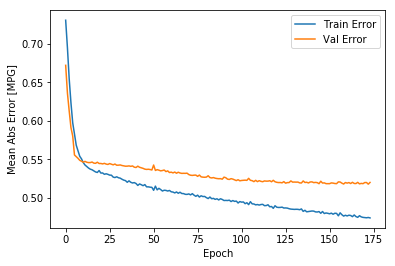

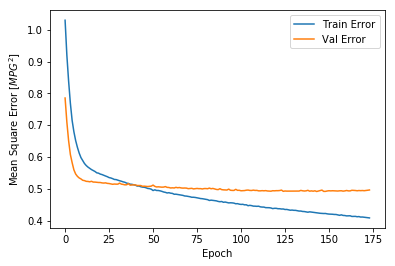

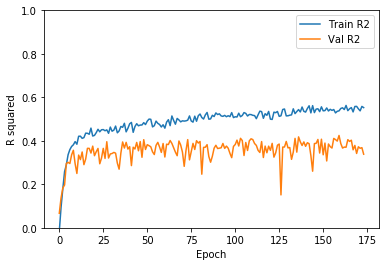

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('R squared')
  plt.plot(hist['epoch'], hist['det_coeff'],
           label='Train R2')
  plt.plot(hist['epoch'], hist['val_det_coeff'],
           label = 'Val R2')
  plt.ylim([0,1])
  plt.legend()

  plt.show()


plot_history(history)


In [26]:
# loss, mae, mse, r2 = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)

In [ ]:
# Compile the model
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
# Fit the model to the training data
deep_model.fit(X_train_scaled, y_train_categorical, epochs=100, shuffle=True, verbose=2)

In [ ]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test_categorical, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")